In [4]:
#import packages
import pandas as pd
import numpy as np
 
#to plot within notebook
import matplotlib.pyplot as plt
 
#setting figure size
from matplotlib.pylab import rcParams
from datetime import datetime

In [8]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
 

new_data = pd.read_csv("data_wsb.csv")

#setting index
new_data.index = new_data.Datetime
new_data.drop('Datetime', axis=1, inplace=True)
 
#creating train and test sets
dataset = new_data.values
 
train = dataset[0:511,:]
valid = dataset[511:,:]
 
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#--------------------------

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
 
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
 
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
 
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
 
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

451/451 - 26s - loss: 0.0157 - 26s/epoch - 57ms/step


In [9]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

5.124809625884811

<ipython-input-10-3fbf0c2687ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


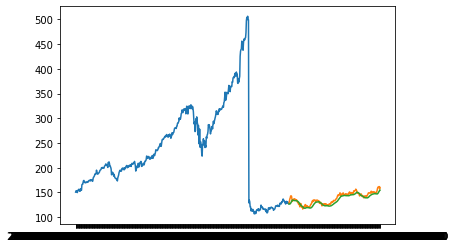

In [10]:
train = new_data[:511]
valid = new_data[511:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])